In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import sys
sys.path.append("../scripts")

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
plt.rcParams["figure.figsize"] = (14,6)

In [10]:
obs = pd.read_csv("../data/obs-ar.csv", parse_dates=["date"])
obs = obs.set_index("date")
obs = obs.drop(columns=["C"])
obs

,I,R,D
date,,,
2020-03-07,1,0,0
2020-03-08,3,0,0
2020-03-09,5,0,0
2020-03-10,7,0,0
2020-03-11,10,0,0
...,...,...,...
2020-06-05,12280,5618,573
2020-06-06,12894,5817,590
2020-06-07,13500,6042,608


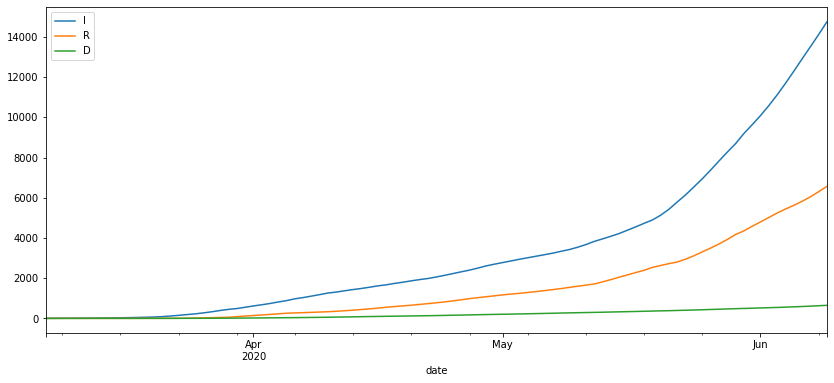

In [11]:
obs.plot()

In [12]:
def train_test_split(data, split, start=None, end=None):
    if start is None:
        start = data.index[0]
    if end is None:
        end = data.index[-1]
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    split = pd.to_datetime(split)
    one = pd.DateOffset(days=1)
    train = data[start:split-one].copy()
    test = data[split:end].copy()
    return train, test

In [13]:
data_start = "2020-04-01"
data_split = "2020-06-01"
train, test = train_test_split(obs, split=data_split, start=data_start)

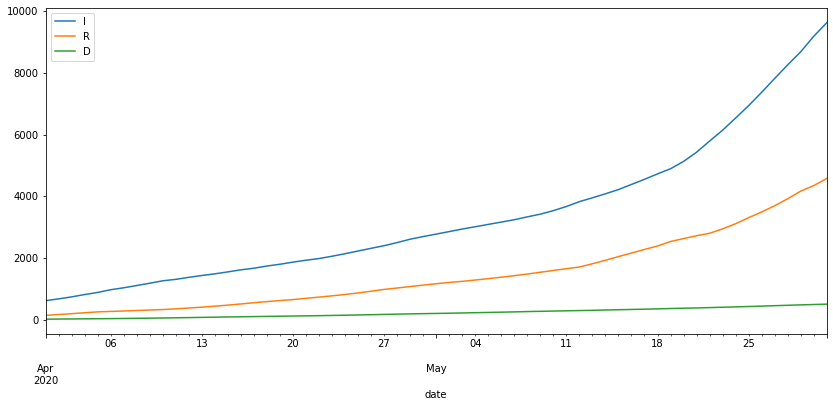

In [14]:
train.plot()

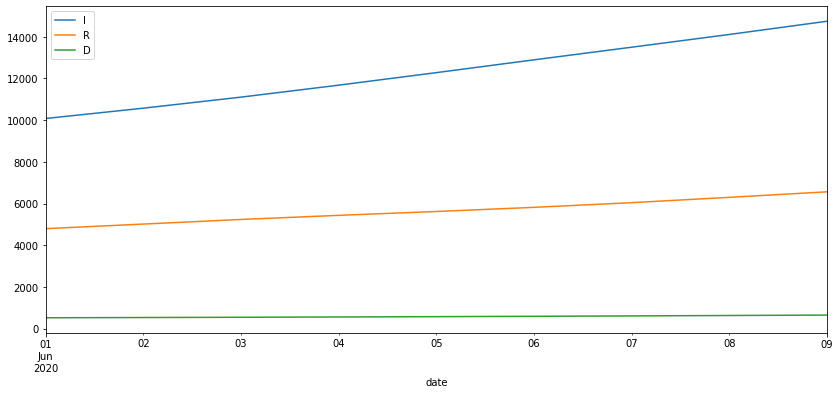

In [15]:
test.plot()

## SIR

In [16]:
from SEIR import SIR

In [17]:
init_I, init_R, init_D = train.head(1).to_numpy().flatten()

In [18]:
model = SIR(population=1e4, init_infected=init_I, init_recovered=init_R, init_dead=init_D)

In [19]:
model.fit(train, estimate=('r_transmission', "r_recovery", "r_mortality", "population"), 
          method="Nelder-Mead", options={"maxiter": 5000})

 final_simplex: (array([[7.08712155e-02, 2.27195857e-02, 3.09922406e-03, 2.60705740e+15],
       [7.08712155e-02, 2.27195857e-02, 3.09922406e-03, 2.60705740e+15],
       [7.08712155e-02, 2.27195857e-02, 3.09922406e-03, 2.60705740e+15],
       [7.08712155e-02, 2.27195857e-02, 3.09922406e-03, 2.60705740e+15],
       [7.08712155e-02, 2.27195857e-02, 3.09922406e-03, 2.60705740e+15]]), array([6538418.82907615, 6538418.82907615, 6538418.82907615,
       6538418.82907615, 6538418.82907615]))
           fun: 6538418.829076154
       message: 'Optimization terminated successfully.'
          nfev: 1524
           nit: 858
        status: 0
       success: True
             x: array([7.08712155e-02, 2.27195857e-02, 3.09922406e-03, 2.60705740e+15])

In [20]:
model.params

{'population': 2607057397024187.0,
 'r_transmission': 0.07087121548528888,
 'r_recovery': 0.022719585739441217,
 'r_mortality': 0.0030992240633050012}

In [21]:
T = len(train) + len(test)
res = model.simulate(until=T)
idx = pd.date_range(start=data_start, periods=T, freq="D")
res.index = idx

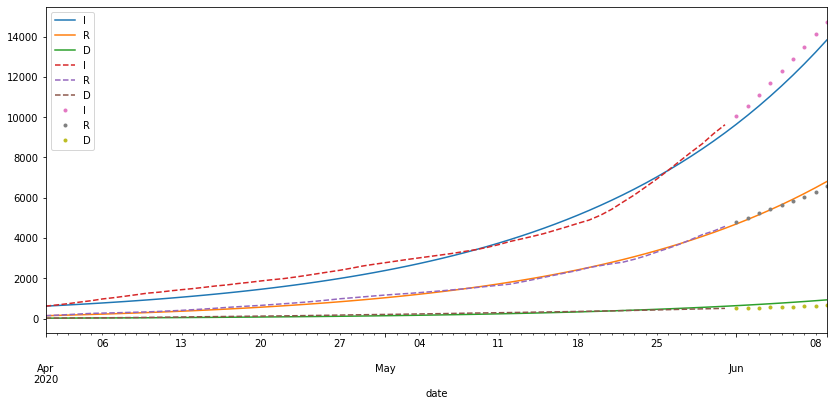

In [22]:
ax = res.plot()
train.plot(ax=ax, style="--")
test.plot(ax=ax, style=".")

## SEIR

In [23]:
from SEIR import SEIR

In [24]:
model = SEIR(population=44e6, init_infected=init_I, init_recovered=init_R, init_dead=init_D, init_exposed=500)

In [25]:
model.fit(train, estimate=('r_transmission', "r_progression", "r_recovery", "r_mortality"),
          method="Nelder-Mead", options={"maxiter": 5000})

 final_simplex: (array([[0.0842704 , 0.02144317, 0.1470241 , 0.00293884],
       [0.08427037, 0.02144316, 0.14702414, 0.00293884],
       [0.08427049, 0.02144317, 0.14702357, 0.00293883],
       [0.08427041, 0.02144317, 0.14702393, 0.00293882],
       [0.08427057, 0.02144318, 0.14702335, 0.00293884]]), array([5165337.31041329, 5165337.31043439, 5165337.31045003,
       5165337.3104735 , 5165337.31050748]))
           fun: 5165337.310413288
       message: 'Optimization terminated successfully.'
          nfev: 771
           nit: 475
        status: 0
       success: True
             x: array([0.0842704 , 0.02144317, 0.1470241 , 0.00293884])

In [26]:
T = len(train) + len(test)
res = model.simulate(until=T)
idx = pd.date_range(start=data_start, periods=T, freq="D")
res.index = idx

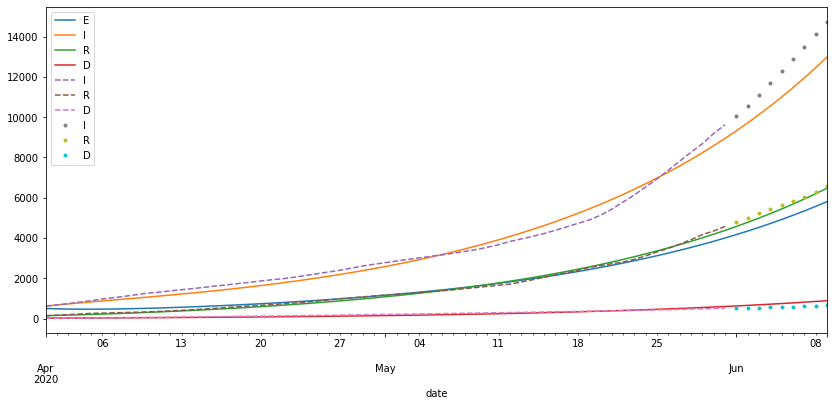

In [27]:
ax = res.plot()
train.plot(ax=ax, style="--")
test.plot(ax=ax, style=".")

## SEIRH

In [28]:
from SEIR import SEIRH

In [29]:
model = SEIRH(init_infected=init_I, init_recovered=init_R, init_dead=init_D, 
              init_exposed=1000, init_hospitalized=100,
              r_hospitalized=0.05, r_recovery_hosp=0.01, r_recovery_mild=0.1)

In [30]:
model.fit(train, estimate=('r_transmission', "r_progression", "r_mortality", 
                           "r_hospitalized", "r_recovery_hosp", "r_recovery_mild"), 
          method="Nelder-Mead", options={"maxiter": 10000})

 final_simplex: (array([[ 1.49485804e-01,  2.14919607e-02,  4.20296192e-03,
         9.42685424e-02, -1.73363130e-05,  4.08369784e-02],
       [ 1.49485862e-01,  2.14918936e-02,  4.20295852e-03,
         9.42685676e-02, -1.72508978e-05,  4.08370955e-02],
       [ 1.49485660e-01,  2.14918582e-02,  4.20297014e-03,
         9.42686144e-02, -1.71955212e-05,  4.08370258e-02],
       [ 1.49485944e-01,  2.14919121e-02,  4.20295102e-03,
         9.42685406e-02, -1.72582762e-05,  4.08371106e-02],
       [ 1.49485829e-01,  2.14919209e-02,  4.20297281e-03,
         9.42685659e-02, -1.72736704e-05,  4.08370479e-02],
       [ 1.49485429e-01,  2.14917917e-02,  4.20295941e-03,
         9.42686608e-02, -1.71090325e-05,  4.08369823e-02],
       [ 1.49485503e-01,  2.14918504e-02,  4.20296103e-03,
         9.42686237e-02, -1.71821646e-05,  4.08369529e-02]]), array([5321003.46078203, 5321003.4607826 , 5321003.4607974 ,
       5321003.46080317, 5321003.46084274, 5321003.46085501,
       5321003.46085828]))

In [31]:
T = len(train) + len(test)
res = model.simulate(until=T)
idx = pd.date_range(start=data_start, periods=T, freq="D")
res.index = idx

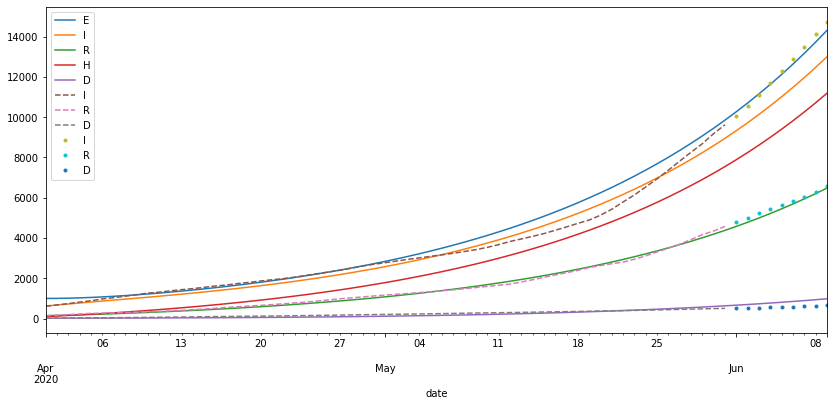

In [32]:
ax = res.plot()
train.plot(ax=ax, style="--")
test.plot(ax=ax, style=".")